In [1]:
!pip install fuzzy-c-means

     |████████████████████████████████| 15.7 MB 52 kB/s 
     |████████████████████████████████| 10.1 MB 37.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fcmeans import FCM
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.metrics import accuracy_score
import graphviz

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/omarbecerrasierra/marketing_analysis/main/traindata.csv")
df = df.drop(columns=["Kidhome", "Teenhome", "NumWebVisitsMonth",	"AcceptedCmp3",
                 "AcceptedCmp4",	"AcceptedCmp5",	"AcceptedCmp1",	"AcceptedCmp2",	"Complain",	"Response",
                 "SecondCycle",	"Basic",	"Graduation",	"Master",	"PhD",	"Divorced",	"Married",
                 "Single",	"Together",	"Widow", "AcceptedCmpOverall",
                 "NumDealsPurchases",	"NumWebPurchases",	"NumCatalogPurchases",	"NumStorePurchases", "Recency"])

def normalization(df):
    return (df - df.min()) / (df.max() - df.min())

X = normalization(df)
X

,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Age,Customer_Days,MntTotal,MntRegularProds
0,0.503625,0.425318,0.442211,0.316522,0.664093,0.334601,0.243094,0.696429,0.948498,0.613189,0.628968
1,0.398325,0.007368,0.005025,0.003478,0.007722,0.003802,0.016575,0.750000,0.161660,0.006836,0.108719
2,0.623933,0.285332,0.246231,0.073623,0.428571,0.079848,0.116022,0.553571,0.446352,0.293526,0.355710
3,0.222456,0.007368,0.020101,0.011594,0.038610,0.011407,0.013812,0.214286,0.198856,0.017692,0.118935
4,0.505009,0.115874,0.216080,0.068406,0.177606,0.102662,0.041436,0.267857,0.230329,0.162043,0.246260
...,...,...,...,...,...,...,...,...,...,...,...
2235,0.531169,0.474883,0.216080,0.105507,0.162162,0.448669,0.682320,0.517857,0.545064,0.438279,0.412258
2236,0.556087,0.271936,0.000000,0.017391,0.000000,0.000000,0.022099,0.892857,0.027182,0.173703,0.259394
2237,0.493295,0.608171,0.241206,0.125797,0.123552,0.045627,0.066298,0.267857,0.221745,0.487736,0.538490
2238,0.602791,0.286671,0.150754,0.124058,0.308880,0.114068,0.168508,0.714286,0.223176,0.312827,0.366290


In [4]:
!pip install -U yellowbrick

     |████████████████████████████████| 271 kB 5.3 MB/s 
     |████████████████████████████████| 14.8 MB 178 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.3
    Uninstalling numpy-1.21.3:
      Successfully uninstalled numpy-1.21.3
  Attempting uninstall: yellowbrick
    Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fuzzy-c-means 1.6.3 requires numpy<2.0.0,>=1.21.1, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Select k Cluster

In [5]:
from sklearn.cluster import KMeans

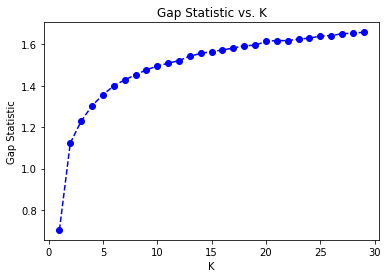

In [6]:
def optimalK(data, nrefs=3, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)
score_g, df = optimalK(X, nrefs=5, maxClusters=30)
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

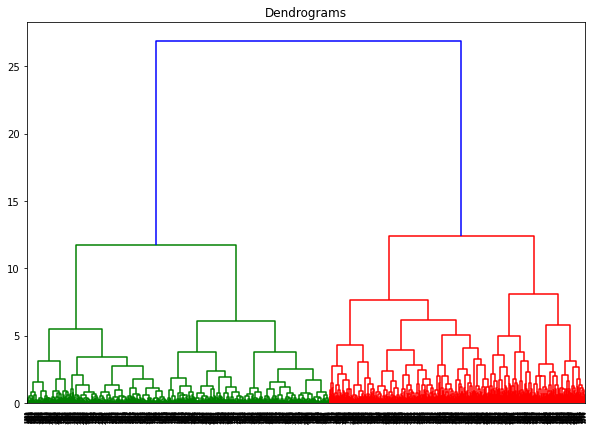

In [7]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

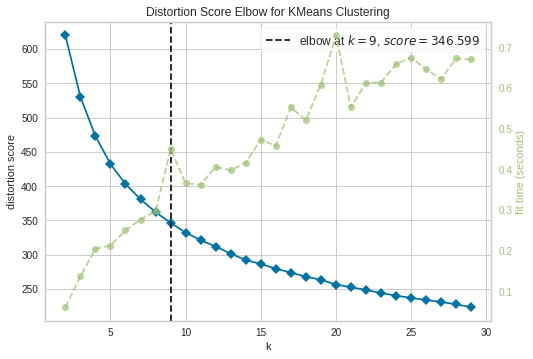

In [8]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(X)        # Fit data to visualizer
visualizer.show()

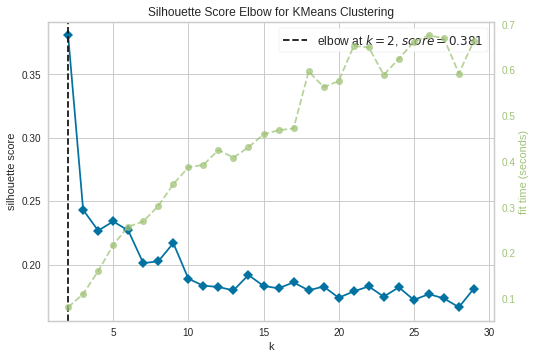

In [9]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

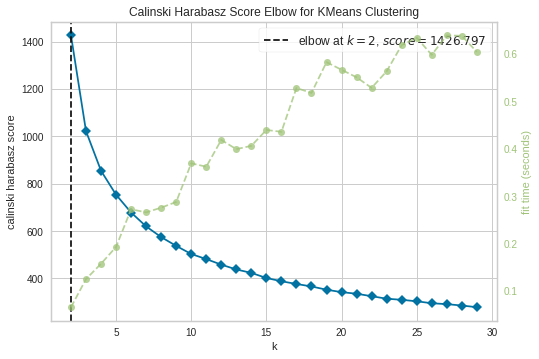

In [10]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()  

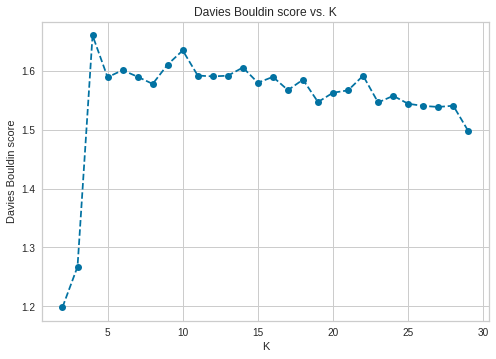

In [11]:
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)
# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    
    return score
scores = []
centers = list(range(2,30))
for center in centers:
    scores.append(get_kmeans_score(X, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');

# Clustering

In [12]:
fcm = FCM(n_clusters=2)
fcm.fit(X.to_numpy())
y = fcm.predict(X.to_numpy())

In [13]:
tsne = TSNE(n_components=2, n_iter=300, n_jobs = -1, perplexity=150)
tsne_3d = tsne.fit_transform(X)
df_tsne_3d = pd.DataFrame(tsne_3d, columns = ["x", "y"])

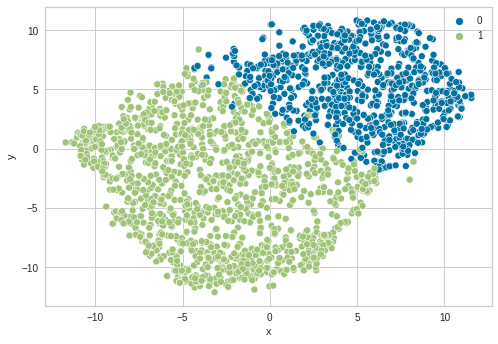

In [14]:
sns.scatterplot(data=df_tsne_3d, x = "x", y = "y", hue = y)

# Auxiliar Functions 

In [15]:
def split_data(df, val = True):
    train = df.sample(frac=0.8)
    test = df.drop(train.index)
    if val == True:
        validation = train.sample(frac = 0.25) # 100*20/80 = 20%
        train = train.drop(validation.index) 
        return train, test, validation
    return train, test
data = X.copy()
data["y"] = y
train, test, validation = split_data(data)

In [16]:
def plot_matriz(y_test, y_pred_val):
    cm = confusion_matrix(y_test, y_pred_val)
    cm_df = pd.DataFrame(cm)
    ax = sns.heatmap(cm_df/np.sum(cm_df), annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

# Trabajo supervisado

## decision tree

In [17]:
clf = tree.DecisionTreeClassifier(max_depth=3,criterion="entropy")
clf.fit(train.drop(columns=["y"]), train.y)
y_pred_ts = clf.predict(test.drop(columns=["y"]))
accuracy_score(test.y, y_pred_ts)

0.9732142857142857

In [18]:
y_pred_val = clf.predict(validation.drop(columns=["y"]))
accuracy_score(validation.y, y_pred_val)

0.984375

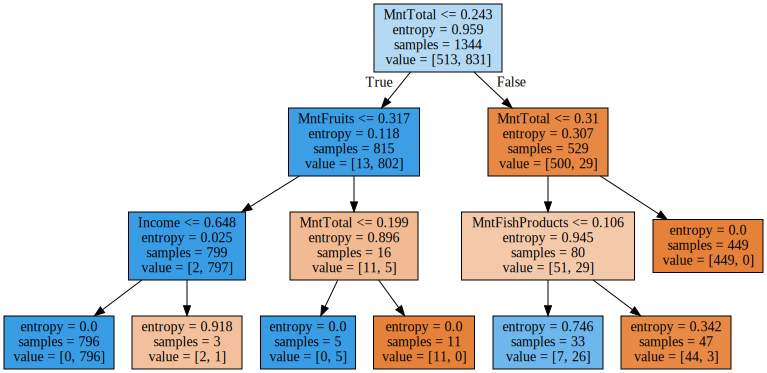

<Figure size 1440x720 with 0 Axes>

In [19]:
ax = plt.figure(figsize=(20, 10))
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X.columns,
                                filled=True)
graphviz.Source(dot_data, format="png") 

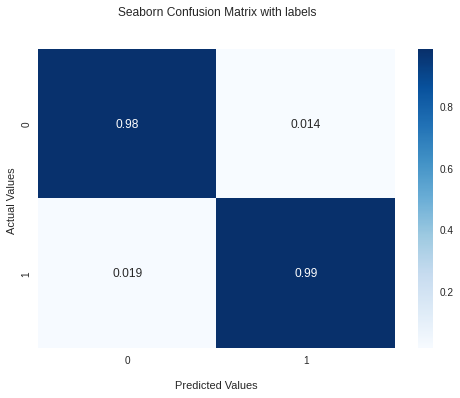

In [20]:
plot_matriz(validation.y, y_pred_val)

## SVM


In [21]:
from sklearn.svm import SVC

### Linear Kernel

In [24]:
clf = SVC(gamma='scale', kernel="linear")
clf.fit(train.drop(columns=["y"]), train.y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [25]:
y_pred_val = clf.predict(validation.drop(columns=["y"]))
accuracy_score(validation.y, y_pred_val)

0.9910714285714286

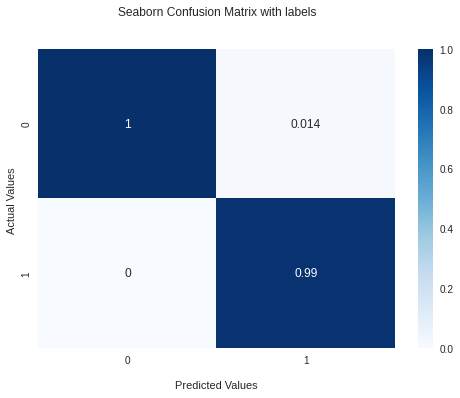

In [27]:
plot_matriz(validation.y, y_pred_val)

### RBF Kernel

In [28]:
clf = SVC(gamma='scale', kernel="rbf")
clf.fit(train.drop(columns=["y"]), train.y)
y_pred_ts = clf.predict(test.drop(columns=["y"]))
accuracy_score(test.y, y_pred_ts)

0.9933035714285714

In [34]:
y_pred_val = clf.predict(validation.drop(columns=["y"]))
accuracy_score(validation.y, y_pred_val)

0.9910714285714286

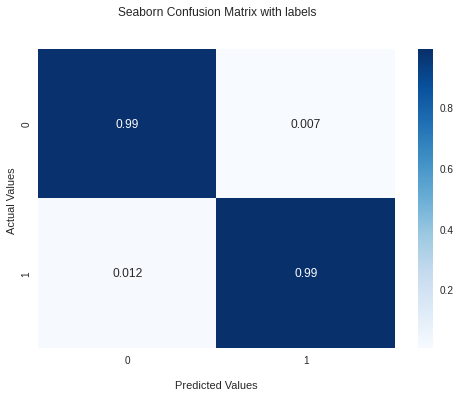

In [35]:
plot_matriz(validation.y, y_pred_val)

### Polinomial Kernel

In [36]:
clf = SVC( gamma='scale', kernel="poly",)
clf.fit(train.drop(columns=["y"]), train.y)
y_pred_ts = clf.predict(test.drop(columns=["y"]))
accuracy_score(test.y, y_pred_ts)

0.9933035714285714

In [37]:
y_pred_val = clf.predict(validation.drop(columns=["y"]))
accuracy_score(validation.y, y_pred_val)

0.9866071428571429

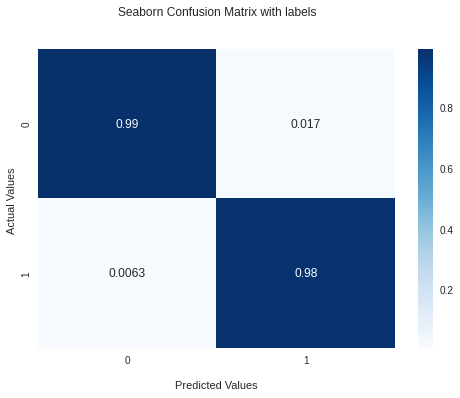

In [38]:
plot_matriz(validation.y, y_pred_val)

## Naive Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB

In [40]:
gnb = GaussianNB()
gnb.fit(train.drop(columns=["y"]), train.y)
y_pred_ts = gnb.predict(test.drop(columns=["y"]))
accuracy_score(test.y, y_pred_ts)

0.9642857142857143

In [41]:
y_pred_val = gnb.predict(validation.drop(columns=["y"]))
accuracy_score(validation.y, y_pred_val)

0.9553571428571429

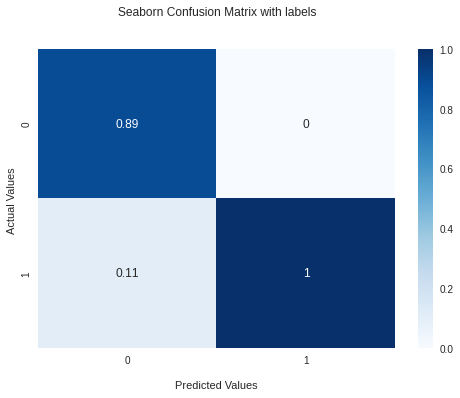

In [42]:
plot_matriz(validation.y, y_pred_val)